In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from data_utils import *
from model_utils import *
import gpytorch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Load data

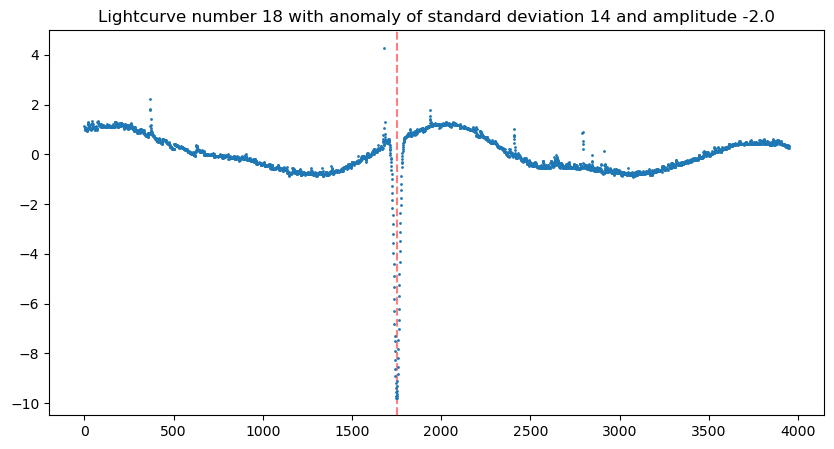

Anomaly locations:
[1750]
38.885416666666664


In [11]:
# Data and anomaly parameters
file_number = 18
shape = "gaussian"
width = 14
amp = -2.0
loc = 1750

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=file_number, 
    shapes=[shape],
    anomaly_stdev=width,
    anomaly_amp=amp,
    anomaly_idx=[loc]
)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Create original copies of x and y
x_orig = np.copy(x)
y_orig = np.copy(y)
y_err_orig = np.copy(y_err)

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
y_err_tensor = torch.tensor(y_err, dtype=torch.float32).to(device)

# Plot
plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y, '.', markersize=2)
plt.title(f"Lightcurve number {file_number} with anomaly of standard deviation {width} and amplitude {amp}")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

# Anomaly detection with GP
### Method:
1. Perform GP regression on the timeseries.
2. Find the most significant outlier point.
3. Exclude that point and redo regression. See if GP improves by some threshold.
4. Exclude adjacent points and redo step 3.
5. Repeat step 4 as long as GP improves the fit by some threshold.
6. If no improvement, define anomaly signal as the difference between data and regression in that interval of points.
7. Repeat steps 2-6 for a defined number of anomalies.

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(




 New dip identified at anomalous index 1739, x[index] = 38.61458333333333


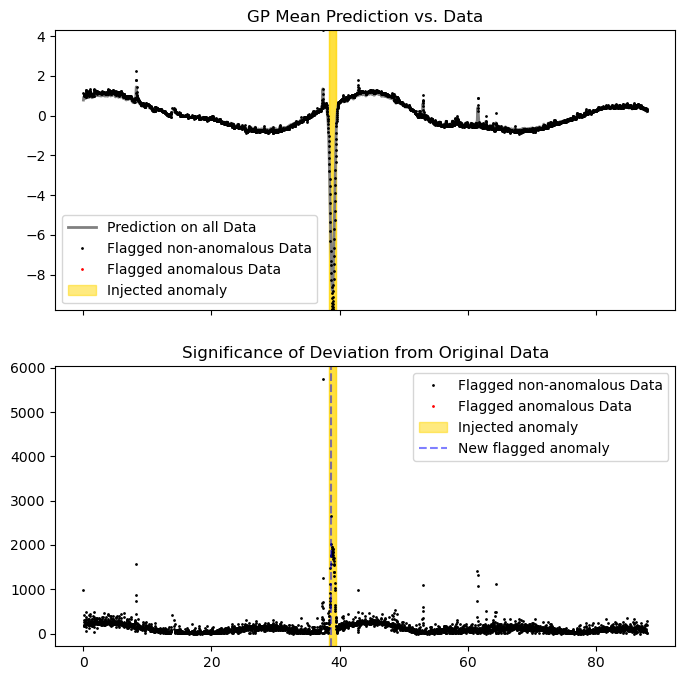

Old metric: 1000000.0 - New metric: 1.026593804359436 = Diff metric: 999999.0
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 1737:1741
Old metric: 1.026593804359436 - New metric: 1.026826024055481 = Diff metric: -0.00023221969604492188
Anomaly index 0 x[i] 0.010416666666666666, left_edge:right_edge 1735:1743


 New dip identified at anomalous index 1735, x[index] = 38.53125


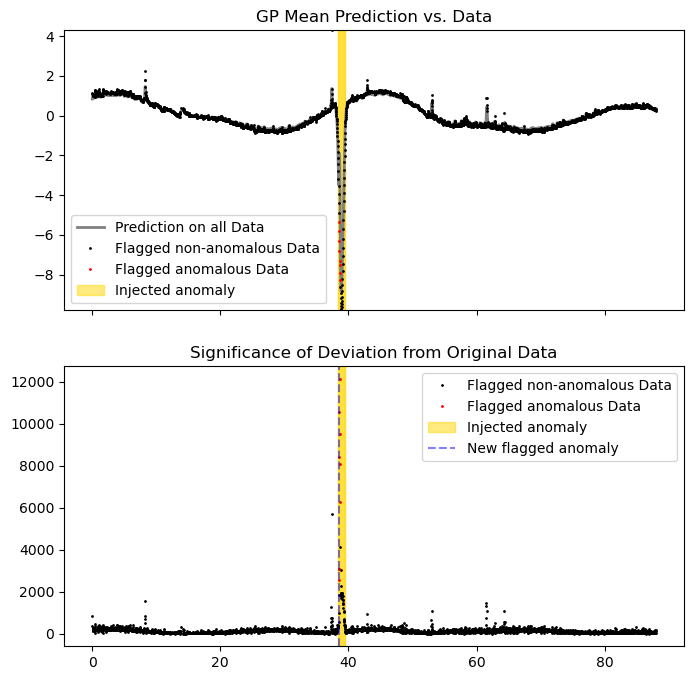

Old metric: 1000000.0 - New metric: 1.02668297290802 = Diff metric: 999999.0
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 1733:1737
Old metric: 1.02668297290802 - New metric: 1.0265858173370361 = Diff metric: 9.715557098388672e-05
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 1731:1739
Old metric: 1.0265858173370361 - New metric: 1.026550054550171 = Diff metric: 3.5762786865234375e-05
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 1729:1741
Old metric: 1.026550054550171 - New metric: 1.026381492614746 = Diff metric: 0.0001685619354248047
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 1727:1743
Old metric: 1.026381492614746 - New metric: 1.0262337923049927 = Diff metric: 0.00014770030975341797
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 1725:1745
Old metric: 1.0262337923049927 - New metric: 1.0262277126312256 = Diff metric: 6.079673767089844e-06
Anomaly index 1 x[i] 0.03125, left_edge:right_edge 1723:1747
Old metric: 1.0262277126312256 - New metric: 1.026111125

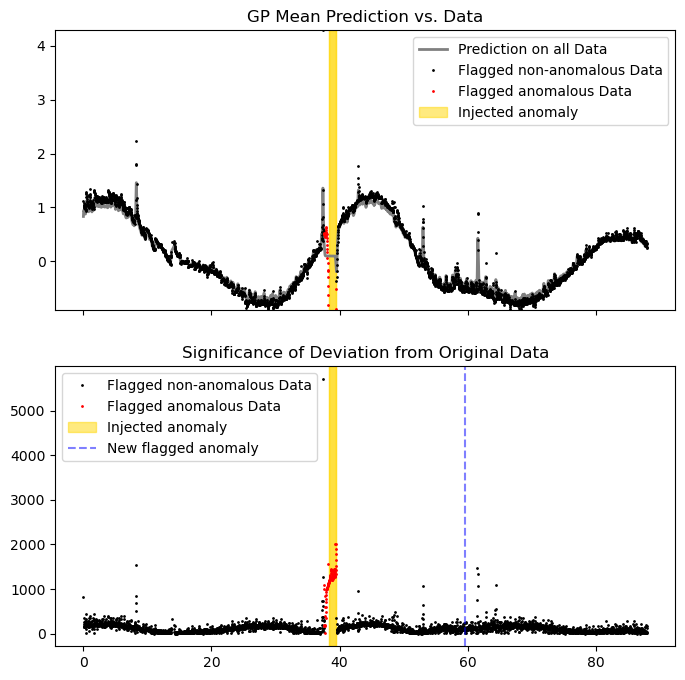

Old metric: 1000000.0 - New metric: 1.023463487625122 = Diff metric: 999999.0
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2701:2705
Old metric: 1.023463487625122 - New metric: 1.0234743356704712 = Diff metric: -1.0848045349121094e-05
Anomaly index 2 x[i] 0.05208333333333333, left_edge:right_edge 2699:2707


 New dip identified at anomalous index 2695, x[index] = 59.36458333333333


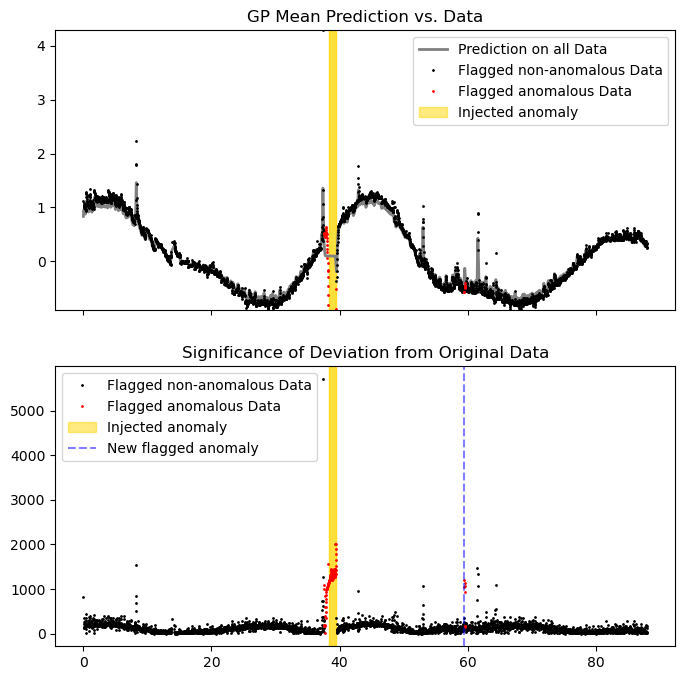

Old metric: 1000000.0 - New metric: 1.0233118534088135 = Diff metric: 999999.0
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 2693:2697
Old metric: 1.0233118534088135 - New metric: 1.023296594619751 = Diff metric: 1.52587890625e-05
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 2691:2699
Old metric: 1.023296594619751 - New metric: 1.023262619972229 = Diff metric: 3.3974647521972656e-05
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 2689:2701
Old metric: 1.023262619972229 - New metric: 1.023430585861206 = Diff metric: -0.00016796588897705078
Anomaly index 3 x[i] 0.07291666666666667, left_edge:right_edge 2687:2703


In [12]:
# Hyperparameters
which_metric = 'msll' # 'rmse', 'nlpd', msll, or default is 'mll'
num_anomalies = 4
num_steps = len(x)
anomalous = np.zeros(num_steps) # 0 means non-anomalous, 1 means anomalous at that time step
initial_lengthscale = 0.3**2 # If None, no lengtshcale is used (default) and the theta parameter is the identity matrix
expansion_param = 2 # how many indices left and right to increase anomaly by

# Train GP model
model, likelihood, mll = train_gp(x_tensor, y_tensor, y_err_tensor, training_iterations=30, lengthscale=initial_lengthscale, device=device)
final_lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()

# Step 7 (repeat for every anomaly)
for i in range(num_anomalies):
    # Get subset of data that is flagged an non-anomalous
    x_sub = torch.tensor(x[anomalous == 0], dtype=torch.float32).to(device)
    y_sub = torch.tensor(y[anomalous == 0], dtype=torch.float32).to(device)
    y_err_sub = torch.tensor(y_err[anomalous == 0], dtype=torch.float32).to(device)

    # Re-fit the GP on non-anomalous data
    model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

    # Predict
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x_tensor))
        pred_mean = observed_pred.mean.cpu().numpy()
        pred_var = observed_pred.variance.cpu().numpy()

    # Find index of largest deviation
    sig_dev = (pred_mean - y) / y_err
    index = np.argmax(sig_dev[anomalous == 0])
    print(f"\n\n New dip identified at anomalous index {index}, x[index] = {x[index]}")

    # Plot
    fig, axs = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
    axs[0].set_title("GP Mean Prediction vs. Data")
    axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
    axs[0].plot(x[(anomalous==0)], y_orig[(anomalous==0)], '.k', markersize=2, label="Flagged non-anomalous Data")
    axs[0].plot(x[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Flagged anomalous Data")
    # Plot the anomaly region
    axs[0].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
    for j in anomaly_locs:
        axs[0].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
    axs[0].set_ylim(np.min(y_sub.cpu().numpy()), np.max(y_sub.cpu().numpy()))
    axs[0].legend()

    sig_dev = (pred_mean - y) / y_err
    axs[1].set_title("Significance of Deviation from Original Data")
    axs[1].plot(x[(anomalous==0)], np.abs(sig_dev[(anomalous==0)]), '.k', markersize=2, label="Flagged non-anomalous Data")
    axs[1].plot(x[(anomalous==1)], np.abs(sig_dev[(anomalous==1)]), '.r', markersize=2, label="Flagged anomalous Data")
    # Plot the anomaly region
    axs[1].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
    for j in anomaly_locs:
        axs[1].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
    # Plot the index of the new anomaly
    axs[1].axvline(x=x[index], color='b', linestyle='--', alpha=0.5, label="New flagged anomaly")
    axs[1].legend()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

    # Intialize variables for expanding anomalous region
    left_edge = index
    right_edge = index
    diff_metric = 1e6
    metric = 1e6
    
    # While the metric is decreasing, expand the anomalous edges
    while diff_metric > 0:
        # Subset x, y, and y_err
        subset = (((np.arange(len(x)) > right_edge) | (np.arange(len(x)) < left_edge)) & (anomalous == 0))
        x_sub = torch.tensor(x[subset], dtype=torch.float32).to(device)
        y_sub = torch.tensor(y[subset], dtype=torch.float32).to(device)
        y_err_sub = torch.tensor(y_err[subset], dtype=torch.float32).to(device)
        
        # Re-fit the GP on non-anomalous data
        model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

        # Predict on subset
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(x_sub))
            pred_mean = observed_pred.mean.cpu().numpy()
            pred_var = observed_pred.variance.cpu().numpy()

        # Calculate metric difference
        old_metric = metric

        if which_metric == 'nlpd':
            metric = gpytorch.metrics.negative_log_predictive_density(observed_pred, y_sub)
        elif which_metric == 'msll':
            metric = gpytorch.metrics.mean_standardized_log_loss(observed_pred, y_sub)
        elif which_metric == 'rmse':
            metric = np.sqrt(np.mean((pred_mean - y_sub.cpu().numpy())**2))
        else: # metric == mll
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                output = model(x_sub)
                metric = mll(output, y_sub)

        diff_metric = old_metric - metric # smaller is better
        print(f"Old metric: {old_metric} - New metric: {metric} = Diff metric: {diff_metric}")

        # Expand anomalous region on both sides
        if left_edge >= 0 + expansion_param:
            left_edge -= expansion_param
        if right_edge < len(x) - expansion_param:
            right_edge += expansion_param

        print(f"Anomaly index {i} x[i] {x[i]}, left_edge:right_edge {left_edge}:{right_edge}")

    # Update anomalous array and remove anomalies from y
    y[left_edge:right_edge] = pred_mean[left_edge:right_edge]
    anomalous[left_edge:right_edge] = 1

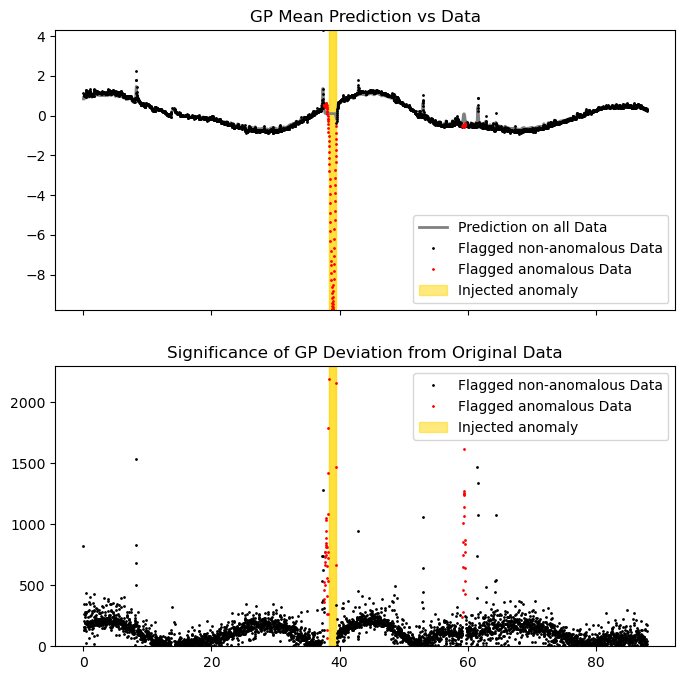

In [13]:
# Fit on final subset
model, likelihood, mll = train_gp(x_sub, y_sub, y_err_sub, training_iterations=1, lengthscale=final_lengthscale, device=device)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))
    pred_mean = observed_pred.mean.cpu().numpy()
    pred_var = observed_pred.variance.cpu().numpy()

# Plot
fig, axs = plt.subplots(2, 1, sharex = True, figsize=(8, 8))
axs[0].set_title("GP Mean Prediction vs Data")
axs[0].plot(x, pred_mean, "grey", lw=2, label="Prediction on all Data")
axs[0].plot(x_sub.cpu().numpy(), y_sub.cpu().numpy(), '.k', markersize=2, label="Flagged non-anomalous Data")
axs[0].set_ylim(np.min(y_orig), np.max(y_orig))
axs[0].plot(x_orig[(anomalous==1)], y_orig[(anomalous==1)], '.r', markersize=2, label="Flagged anomalous Data")
# Plot the anomaly region
axs[0].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
for j in anomaly_locs:
    axs[0].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
axs[0].legend(loc='lower right')

sigdev = (pred_mean - y_orig) / y_err_orig
axs[1].set_title("Significance of GP Deviation from Original Data")
axs[1].plot(x[(anomalous==0)], np.abs(sigdev[(anomalous==0)]), '.k', markersize=2, label="Flagged non-anomalous Data")
axs[1].plot(x[(anomalous==1)], np.abs(sigdev[(anomalous==1)]), '.r', markersize=2, label="Flagged anomalous Data")
# Plot the anomaly region
axs[1].axvspan(x[int(anomaly_locs[0])] - 0.5, x[int(anomaly_locs[0])] + 0.5, color='gold', alpha=0.5, label="Injected anomaly")
for j in anomaly_locs:
    axs[1].axvspan(x[int(j)] - 0.5, x[int(j)] + 0.5, color='gold', alpha=0.5)
axs[1].set_ylim(0, 20 * np.median(np.abs(sigdev[(anomalous==0)])))
axs[1].legend(loc='upper right')
plt.show(block=True)

In [14]:
# Check whether every anomaly_locs was identified in the anomalous array
identified = np.zeros(len(anomaly_locs))
flagged_anomalies = np.where(anomalous == 1)

for i in range(len(anomaly_locs)):
    anomaly = int(anomaly_locs[i])

    if np.isin(anomaly, flagged_anomalies):
        identified[i] = 1
    else:
        print(f"Anomaly at index {anomaly} was not identified in the anomalous array")

identified_ratio = np.sum(identified) / len(anomaly_locs)

print(f"Injected anomaly centers: {anomaly_locs}")
print(f"Anomalies identified: {identified}")
print(f"Ratio of anomalies identified: {identified_ratio}")
print(f"Flagged anomalies: {flagged_anomalies}")

Injected anomaly centers: [1750]
Anomalies identified: [1.]
Ratio of anomalies identified: 1.0
Flagged anomalies: (array([1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701,
       1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712,
       1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723,
       1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734,
       1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745,
       1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756,
       1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767,
       1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778,
       2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697,
       2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706]),)
